In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

data collection

In [3]:
df_rawraw = pd.read_excel(r"C:\Users\choiy\OneDrive\바탕 화면\Final_Project\1. Dataset\식중독 지역별 현황.xlsx")

In [4]:
import pandas as pd
import itertools

years = list(range(2002, 2025)) 
months = list(range(1, 13))
provinces = df_rawraw['OCCRNC_AREA'].unique() 

all_combinations = pd.DataFrame(list(itertools.product(years, months, provinces)), 
                                columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_AREA'])

df_rawraw['OCCRNC_YEAR'] = df_rawraw['OCCRNC_YEAR'].astype(str)
all_combinations['OCCRNC_YEAR'] = all_combinations['OCCRNC_YEAR'].astype(str)

df_rawraw['OCCRNC_MM'] = df_rawraw['OCCRNC_MM'].astype(int)
all_combinations['OCCRNC_MM'] = all_combinations['OCCRNC_MM'].astype(int)

df_merged = pd.merge(all_combinations, df_rawraw, on=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_AREA'], how='left')

df_rawraw = df_merged.sort_values(by=['OCCRNC_YEAR', 'OCCRNC_AREA', 'OCCRNC_MM'], ascending = [False, True, True])
df_raw = df_rawraw.reset_index(drop=True) 

In [5]:
df_order = df_raw.sort_values(by=['OCCRNC_YEAR', 'OCCRNC_MM'], ascending = True)
df_order.fillna(0,inplace=True)

In [6]:
event_dict = {}

for i, row in df_order.iterrows():
    if int(row['OCCRNC_MM']) <10:
        date = str(row['OCCRNC_YEAR'])+'-0'+str(row['OCCRNC_MM'])
    else:
        date = str(row['OCCRNC_YEAR'])+'-'+str(row['OCCRNC_MM'])
    
    event_dict.setdefault(date, 0)
    event_dict[date] += int(row['OCCRNC_CNT'])

In [7]:
event_dict2 = {}

for i, row in df_order.iterrows():
    if int(row['OCCRNC_MM']) <10:
        date = str(row['OCCRNC_YEAR'])+'-0'+str(row['OCCRNC_MM'])
    else:
        date = str(row['OCCRNC_YEAR'])+'-'+str(row['OCCRNC_MM'])
    
    event_dict2.setdefault(date, 0)
    event_dict2[date] += int(row['PATNT_CNT'])

In [8]:
del event_dict['2024-09']
del event_dict['2024-10']
del event_dict['2024-11']
del event_dict['2024-12']

In [9]:
del event_dict2['2024-09']
del event_dict2['2024-10']
del event_dict2['2024-11']
del event_dict2['2024-12']

In [10]:
df_date = pd.DataFrame(list(event_dict.items()), columns = ['date', 'event'])

In [11]:
df_date2 = pd.DataFrame(list(event_dict2.items()), columns = ['date', 'event'])

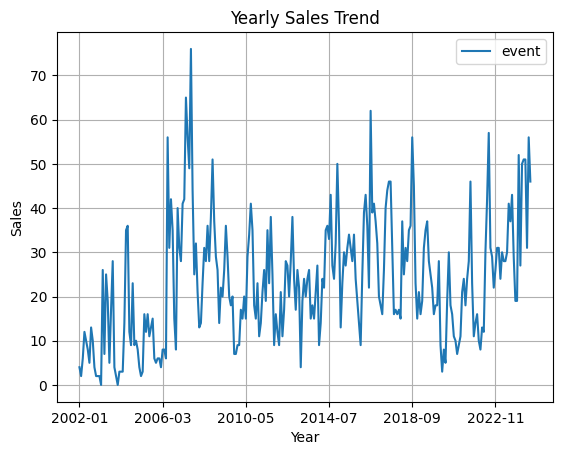

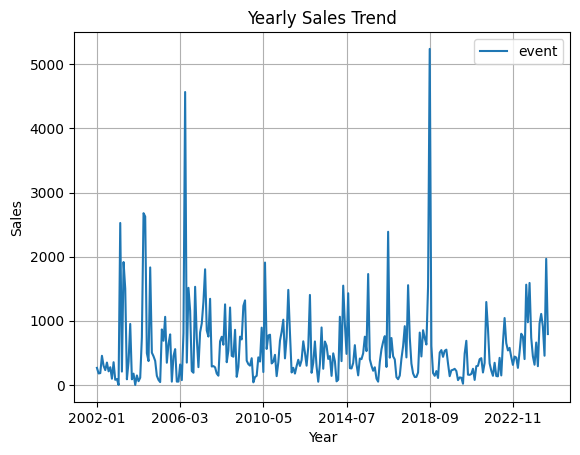

In [12]:
df_date.plot(x='date', y='event', kind='line')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Yearly Sales Trend')
plt.grid(True)
plt.show()

df_date2.plot(x='date', y='event', kind='line')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Yearly Sales Trend')
plt.grid(True)
plt.show()

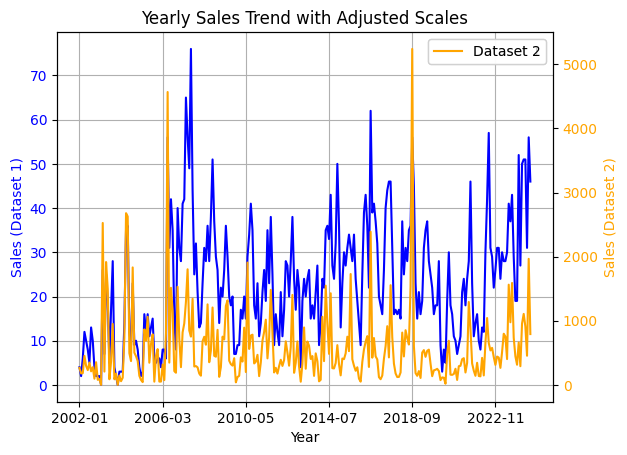

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

df_date.plot(x='date', y='event', kind='line', ax=ax1, color='blue', label='Dataset 1')

ax1.set_xlabel('Year')
ax1.set_ylabel('Sales (Dataset 1)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

df_date2.plot(x='date', y='event', kind='line', ax=ax2, color='orange', label='Dataset 2')

ax2.set_ylabel('Sales (Dataset 2)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Yearly Sales Trend with Adjusted Scales')
ax1.grid(True)

plt.show()


lstm

In [14]:
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping 
from keras.layers import LSTM, Dropout, Dense
from keras.layers import BatchNormalization


In [15]:
df_correct = df_date.set_index(['date'])

In [16]:
df_resample = df_correct.rename(columns={'event': 'y'})
df_resample


,y
date,
2002-01,4
2002-02,2
2002-03,6
2002-04,12
2002-05,10
...,...
2024-04,51
2024-05,51
2024-06,31


In [ ]:
def create_lags(df, days=7):
    for i in range(days):
        df["Lag_{lag}".format(lag=i+1)] = df['y'].shift(i+1)
    return df

def create_features(X, time_steps=1, n_features=7):
    cols, names = list(), list()
    for i in range(1, time_steps+1):
        cols.append(X.shift(-time_steps))
        names += [name + "_" + str(i) for name in X.columns]
        agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    agg = agg.values.reshape(agg.shape[0], time_steps, n_features)
    return agg

def create_dataset(df, yhat):
    preds = pd.DataFrame(yhat.flatten())
    temp = pd.concat([df.iloc[:,0], preds])
    temp.columns = ['y']
    date_idx = pd.date_range(start='2002-08', periods=temp.shape[0])
    temp.set_index(date_idx, inplace=True)
    return temp

In [18]:
train_num= 200
val_num = 220

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

chosen = df_resample.copy()
chosen = create_lags(chosen)
chosen.dropna(inplace=True) 

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaler_x.fit(chosen.iloc[:train_num, 1:].values)
scaler_y.fit(chosen.iloc[:train_num, 0].values.reshape(-1, 1)) 

x_scaled = scaler_x.transform(chosen.iloc[:, 1:])
y_scaled = scaler_y.transform(chosen.loc[:, ['y']])

scaled = np.hstack((x_scaled, y_scaled))
scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)

print(scaled.shape)
scaled.head()


(265, 8)


,y,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
date,,,,,,,,
2002-08,0.065789,0.105263,0.131579,0.157895,0.078947,0.026316,0.052632,0.171053
2002-09,0.171053,0.065789,0.105263,0.131579,0.157895,0.078947,0.026316,0.131579
2002-10,0.131579,0.171053,0.065789,0.105263,0.131579,0.157895,0.078947,0.052632
2002-11,0.052632,0.131579,0.171053,0.065789,0.105263,0.131579,0.157895,0.026316
2002-12,0.026316,0.052632,0.131579,0.171053,0.065789,0.105263,0.131579,0.026316


In [20]:
train = scaled[:train_num]
val = scaled[train_num:val_num]
test = scaled[val_num:]

x_train = train.drop(["y"],axis=1)
y_train = train["y"]
x_val = val.drop(["y"],axis=1)
y_val = val["y"]
x_test = test.drop(["y"],axis=1)
y_test = test["y"]

In [21]:
x_train_np = create_features(x_train, 7, 7)
x_val_np = create_features(x_val, 7, 7)
x_test_np = create_features(x_test, 7, 7)
#print(x_train_np.shape, x_val_np.shape, x_test_np.shape)
y_test = y_test[:x_test_np.shape[0]]
y_train = y_train[:x_train_np.shape[0]]
y_val = y_val[:x_val_np.shape[0]]
#print(y_train.shape, y_val.shape, y_test.shape)

In [22]:
def fit_model(m, units, x_train_np, x_val_np, verbose=False):
    model = Sequential()
    model.add(m (units = units, return_sequences = True, input_shape = [x_train_np.shape[1], x_train_np.shape[2]]))
    # model.add(Dropout(0.2))
    model.add(m (units = units))
    # model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    # Compile Model
    model.compile(loss='mse', optimizer='adam')
    # Fit Model
    history = model.fit(x_train_np, y_train, epochs=50, batch_size=70, 
                        validation_data=(x_val_np, y_val), verbose=False, shuffle=False)
    return model

In [23]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU

RNN_model = fit_model(SimpleRNN, 62, x_train_np, x_val_np)
LSTM_model = fit_model(LSTM, 62, x_train_np, x_val_np)
GRU_model = fit_model(GRU, 62, x_train_np, x_val_np)

In [24]:
RNN_preds = RNN_model.predict(x_test_np)
LSTM_preds = LSTM_model.predict(x_test_np)
GRU_preds = GRU_model.predict(x_test_np)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002327FC54C10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


# RNN

In [25]:
resultsDict = {}

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"rmse": rmse, "mae": mae, "r2": r2, "mape": mape}


In [27]:
rnn_preds = scaler_y.inverse_transform(RNN_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['RNN'] = evaluate(y_test_actual, rnn_preds)
evaluate(y_test_actual, rnn_preds)

{'rmse': 10.025301025894098,
 'mae': 7.287545179065905,
 'r2': 0.24987275944953646,
 'mape': 36.81948349639285}

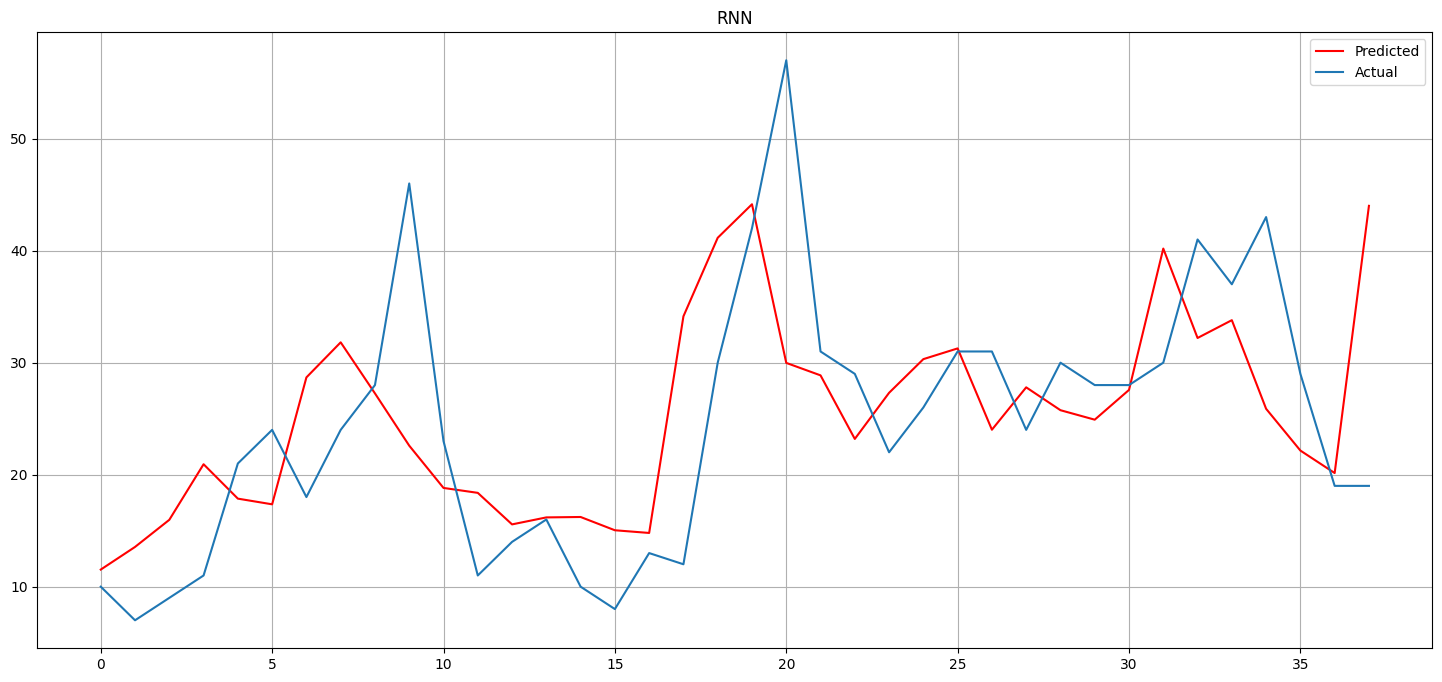

In [28]:
plt.figure(figsize=(18,8))
plt.plot(rnn_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('RNN')
plt.legend()
plt.grid(True)
plt.savefig('1 - RNN.jpg', dpi=200)
plt.show()

# LSTM

In [29]:
lstm_preds = scaler_y.inverse_transform(LSTM_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['LSTM'] = evaluate(y_test_actual, lstm_preds)
evaluate(y_test_actual, lstm_preds)

{'rmse': 9.769631155978932,
 'mae': 7.049480111975419,
 'r2': 0.28764507958571406,
 'mape': 36.26961419662823}

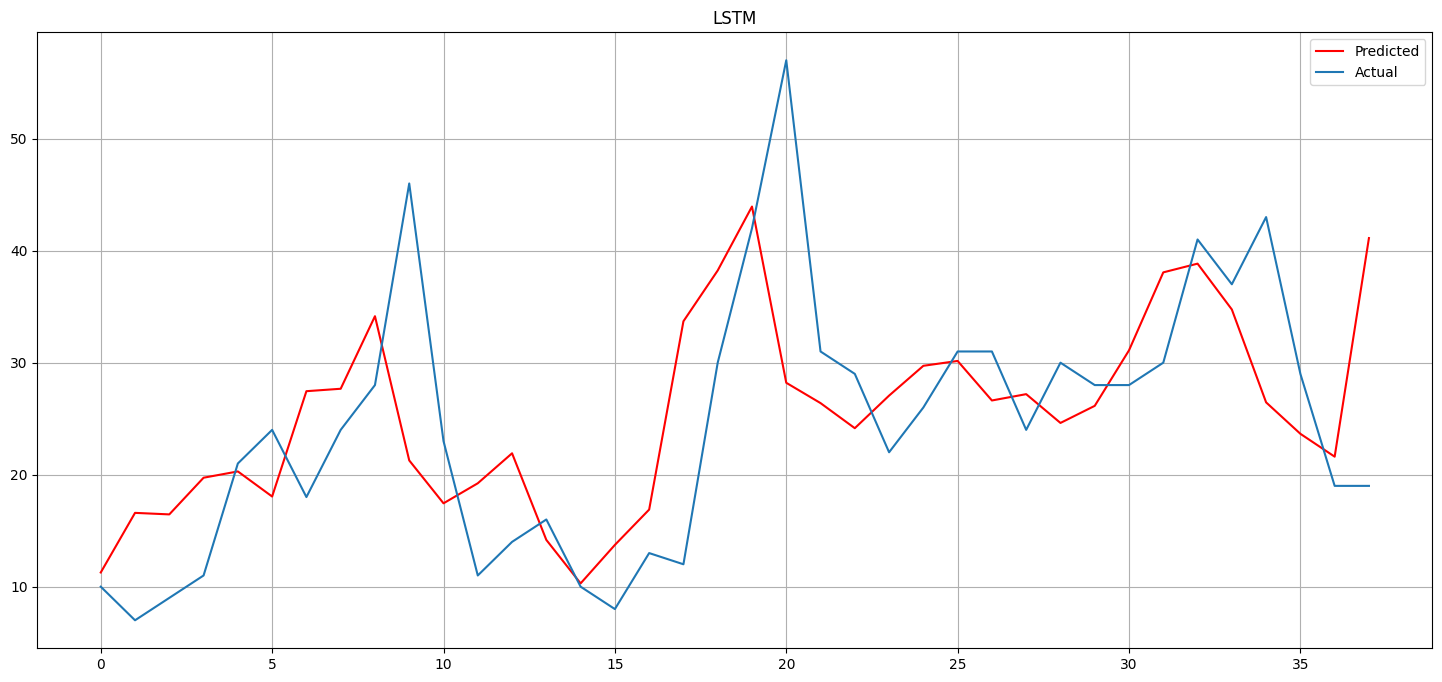

In [30]:
plt.figure(figsize=(18,8))
plt.plot(lstm_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('LSTM')
plt.legend()
plt.grid(True)
plt.savefig('2 - LSTM.jpg', dpi=200)
plt.show()

# GRU

In [31]:
gru_preds = scaler_y.inverse_transform(GRU_preds)
y_test_actual = scaler_y.inverse_transform(pd.DataFrame(y_test))
resultsDict['GRU'] = evaluate(y_test_actual, gru_preds)
evaluate(y_test_actual, gru_preds)

{'rmse': 9.837016689758538,
 'mae': 7.123783387635884,
 'r2': 0.2777843258077223,
 'mape': 36.51197288062989}

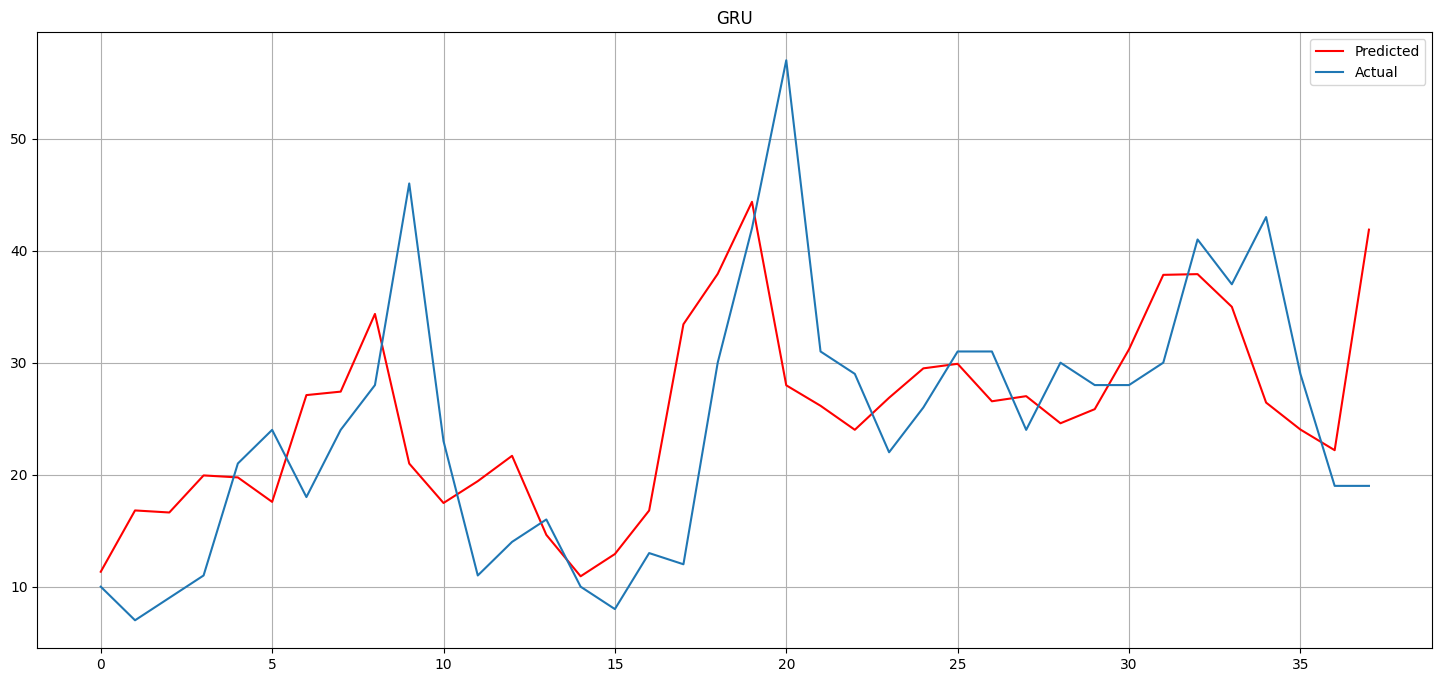

In [32]:
plt.figure(figsize=(18,8))
plt.plot(gru_preds, "r-", label="Predicted")
plt.plot(y_test_actual, label="Actual")
plt.title('GRU')
plt.legend()
plt.grid(True)
plt.savefig('3 - GRU.jpg', dpi=200)
plt.show()

# Rolling Forecast

In [33]:
df_resample

,y
date,
2002-01,4
2002-02,2
2002-03,6
2002-04,12
2002-05,10
...,...
2024-04,51
2024-05,51
2024-06,31


In [34]:
chosen = df_resample.copy()  
chosen = create_lags(chosen) 
chosen.dropna(inplace=True)  

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaler_x.fit(chosen.iloc[:train_num, 1:].values)  
scaler_y.fit(chosen.iloc[:train_num, 0].values.reshape(-1, 1))  

x_scaled = scaler_x.transform(chosen.iloc[:, 1:])  
y_scaled = scaler_y.transform(chosen.loc[:, ['y']]) 

scaled = np.hstack((x_scaled, y_scaled))
scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)

train = scaled[:train_num]
val = scaled[train_num:val_num]
test = scaled[val_num:]

x_train = train.drop(["y"],axis=1)
y_train = train["y"]
x_val = val.drop(["y"],axis=1)
y_val = val["y"]
x_test = test.drop(["y"],axis=1)
y_test = test["y"]

In [35]:
## Helper Function
i = 0
def train_test_split(df, i=0):
    chosen = create_lags(df)
    chosen.dropna(inplace=True)
    x_scaled = scaler_x.transform(chosen.iloc[:,1:])
    y_scaled = scaler_y.transform(chosen.loc[:,['y']])

    scaled = np.hstack((x_scaled, y_scaled))
    scaled = pd.DataFrame(scaled, index=chosen.index, columns=chosen.columns)

    train = scaled[:191+i]
    val = scaled[191+i:232+i]
    test = scaled[232+i:]

    train = scaled[:train_num+i]
    val = scaled[train_num+i:val_num+i]
    test = scaled[val_num+i:]
    
    x_train = train.drop(["y"],axis=1)
    y_train = train["y"]
    x_val = val.drop(["y"],axis=1)
    y_val = val["y"]
    x_test = test.drop(["y"],axis=1)
    y_test = test["y"]

    n_features = len(x_train.columns)
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(df_resample, i)
print(x_test.shape)

(45, 7)


In [36]:
TIME_STEPS, N_FEATURES = 7, 7
rnn, lstm, gru = list(), list(), list()

for i in range(0, len(x_test), 30):
    temp = df_resample.copy()
    x_train, x_val, x_test, y_train, y_val, y_test = train_test_split(temp, i)
    
    x_train_np = create_features(x_train, TIME_STEPS, N_FEATURES)
    x_val_np = create_features(x_val, TIME_STEPS, N_FEATURES)
    x_test_np = create_features(x_test, TIME_STEPS, N_FEATURES)
    #print(x_train_np.shape, x_val_np.shape, x_test_np.shape)
    y_test = y_test[:x_test_np.shape[0]]
    y_train = y_train[:x_train_np.shape[0]]
    y_val = y_val[:x_val_np.shape[0]]
    #print(y_train.shape, y_val.shape, y_test.shape)
    
    if y_test.shape[0] != 0:
        RNN_model = fit_model(SimpleRNN, 64, x_train_np, x_val_np)
        LSTM_model = fit_model(LSTM, 64, x_train_np, x_val_np)
        GRU_model = fit_model(GRU, 64, x_train_np, x_val_np)

        RNN_preds = RNN_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(RNN_preds)
        rnn.extend(yhat_actual.flatten()[:30])
        LSTM_preds = LSTM_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(LSTM_preds)
        lstm.extend(yhat_actual.flatten()[:30])
        GRU_preds = GRU_model.predict(x_test_np)
        yhat_actual = scaler_y.inverse_transform(GRU_preds)
        gru.extend(yhat_actual.flatten()[:30])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


In [37]:
y_test_actual[7:]

array([[24.],
       [28.],
       [46.],
       [23.],
       [11.],
       [14.],
       [16.],
       [10.],
       [ 8.],
       [13.],
       [12.],
       [30.],
       [42.],
       [57.],
       [31.],
       [29.],
       [22.],
       [26.],
       [31.],
       [31.],
       [24.],
       [30.],
       [28.],
       [28.],
       [30.],
       [41.],
       [37.],
       [43.],
       [29.],
       [19.],
       [19.]])

In [38]:
resultsDict['RNN Rolling'] = evaluate(y_test_actual[7:], rnn)
evaluate(y_test_actual[7:], rnn)

{'rmse': 9.978707100085291,
 'mae': 7.177386591511388,
 'r2': 0.214190334807839,
 'mape': 52.724050024722445}

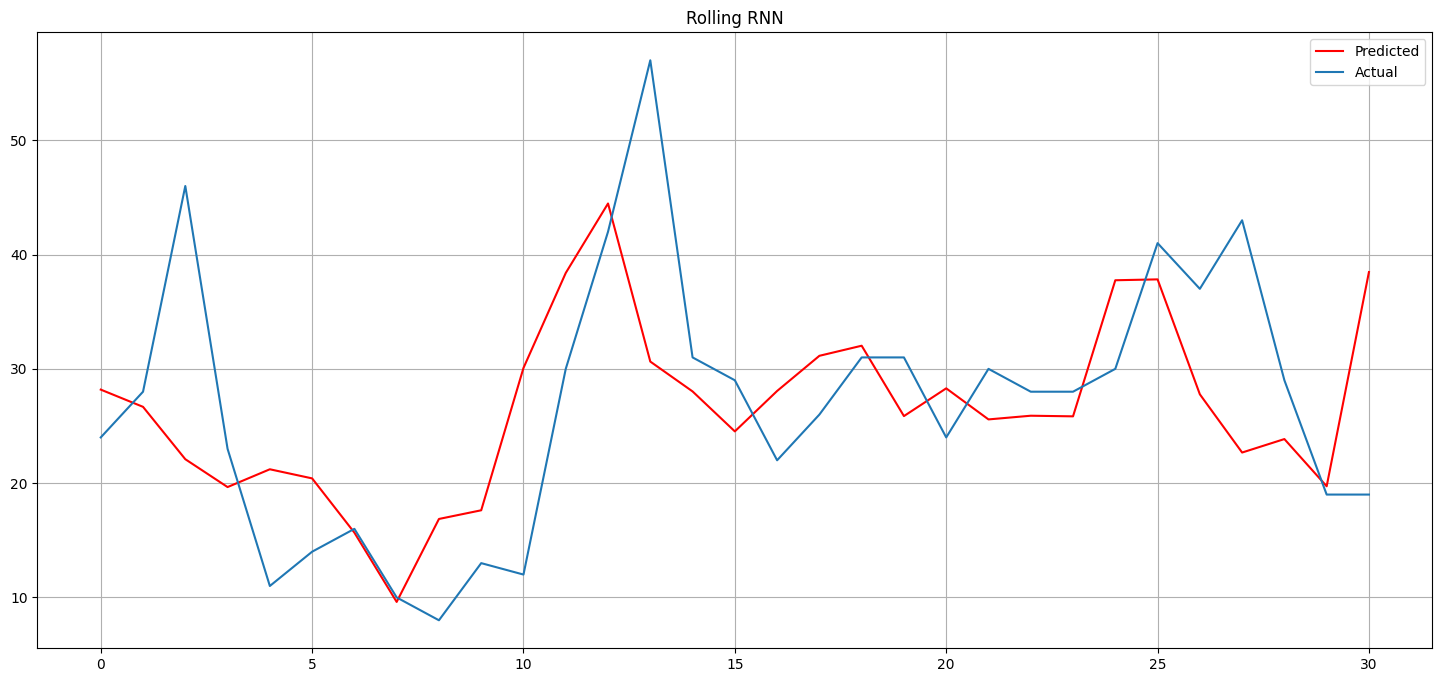

In [39]:
plt.figure(figsize=(18,8))
plt.plot(rnn, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling RNN')
plt.grid(True)
plt.savefig('4 - RNN (Rolling).jpg', dpi=200)
plt.show()

In [40]:
resultsDict['LSTM Rolling'] = evaluate(y_test_actual[7:], lstm)
evaluate(y_test_actual[7:], lstm)

{'rmse': 10.45564951995814,
 'mae': 7.307892245631064,
 'r2': 0.13727804608769478,
 'mape': 55.33192990932729}

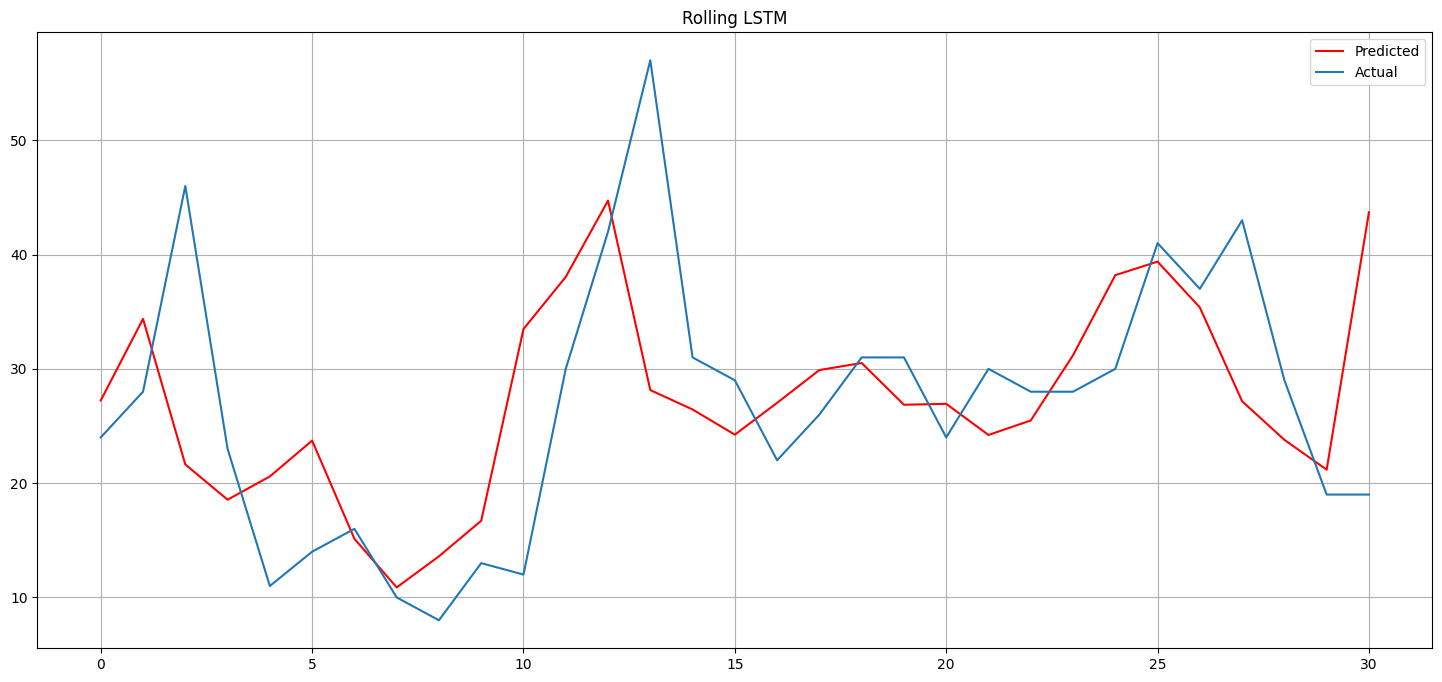

In [41]:
plt.figure(figsize=(18,8))
plt.plot(lstm, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling LSTM')
plt.grid(True)
plt.savefig('5 - LSTM (Rolling).jpg', dpi=200)
plt.show()

In [42]:
resultsDict['GRU Rolling'] = evaluate(y_test_actual[7:], gru)
evaluate(y_test_actual[7:], gru)

{'rmse': 10.356584769098141,
 'mae': 7.244694094504079,
 'r2': 0.15354876242535775,
 'mape': 55.12523876284322}

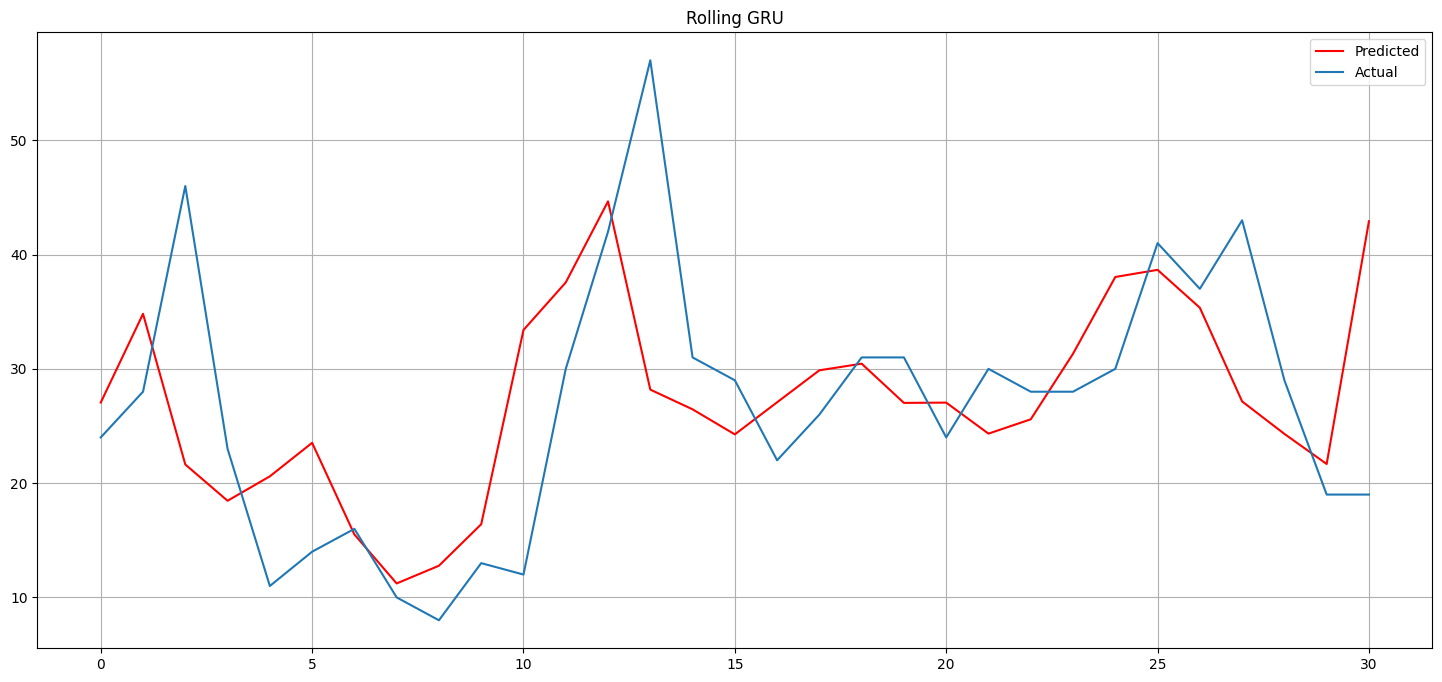

In [43]:
plt.figure(figsize=(18,8))
plt.plot(gru, "r-", label="Predicted")
plt.plot(y_test_actual[7:], label="Actual")
plt.legend()
plt.title('Rolling GRU')
plt.grid(True)
plt.savefig('6 - GRU (Rolling).jpg', dpi=200)
plt.show()

In [44]:
resultsDict

{'RNN': {'rmse': 10.025301025894098,
  'mae': 7.287545179065905,
  'r2': 0.24987275944953646,
  'mape': 36.81948349639285},
 'LSTM': {'rmse': 9.769631155978932,
  'mae': 7.049480111975419,
  'r2': 0.28764507958571406,
  'mape': 36.26961419662823},
 'GRU': {'rmse': 9.837016689758538,
  'mae': 7.123783387635884,
  'r2': 0.2777843258077223,
  'mape': 36.51197288062989},
 'RNN Rolling': {'rmse': 9.978707100085291,
  'mae': 7.177386591511388,
  'r2': 0.214190334807839,
  'mape': 52.724050024722445},
 'LSTM Rolling': {'rmse': 10.45564951995814,
  'mae': 7.307892245631064,
  'r2': 0.13727804608769478,
  'mape': 55.33192990932729},
 'GRU Rolling': {'rmse': 10.356584769098141,
  'mae': 7.244694094504079,
  'r2': 0.15354876242535775,
  'mape': 55.12523876284322}}

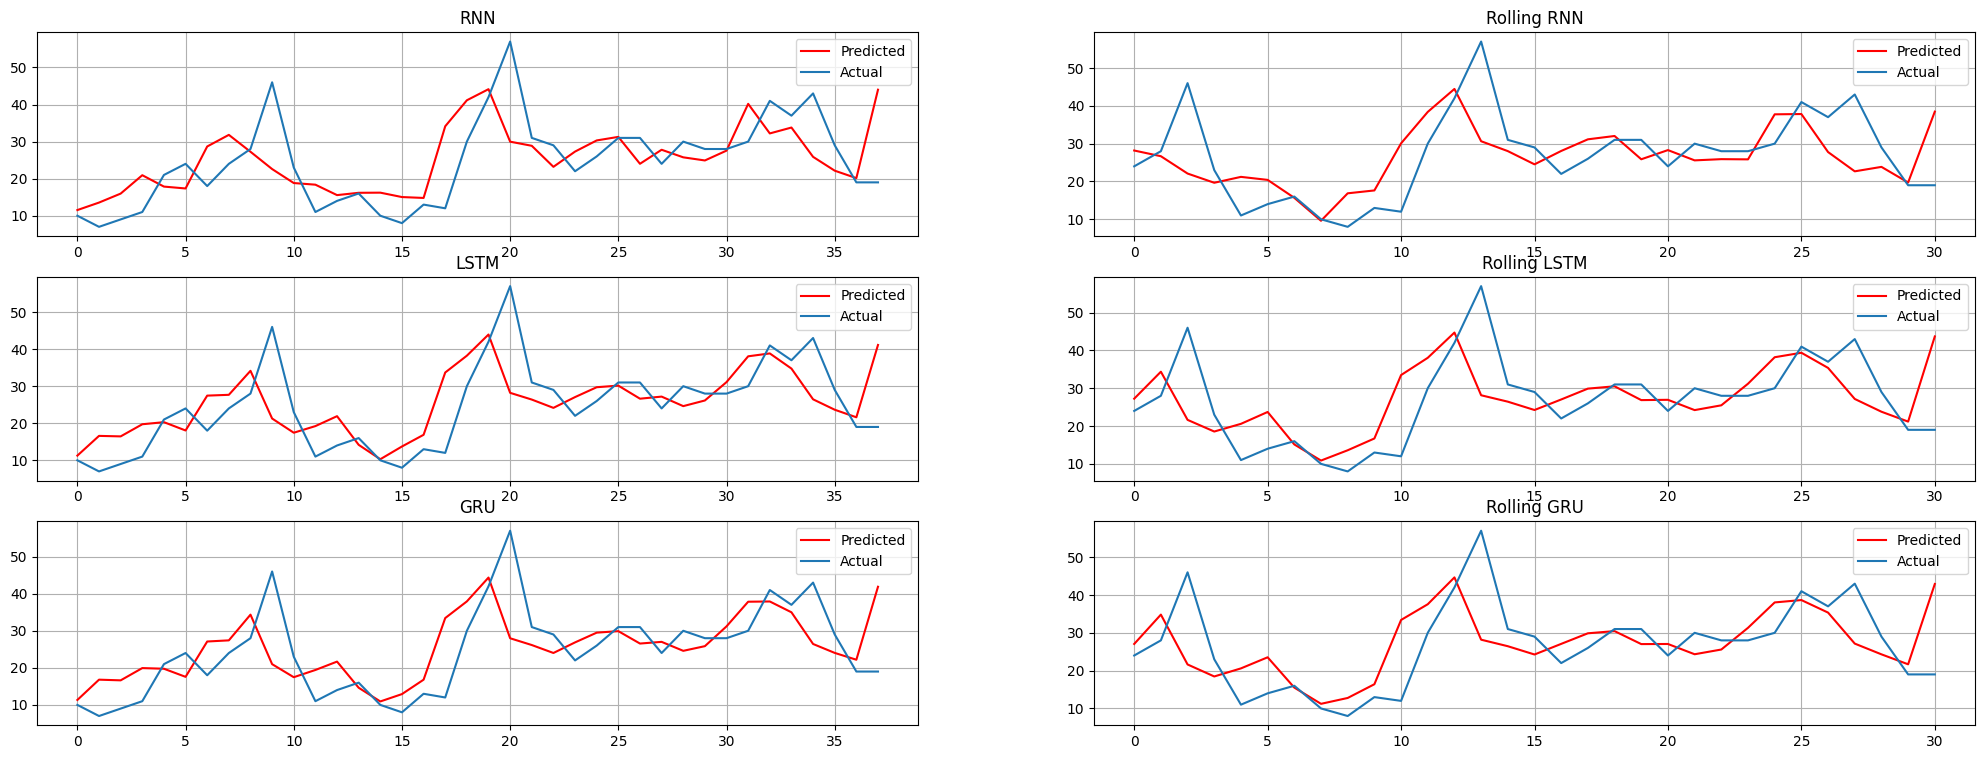

In [45]:
fig,a =  plt.subplots(3,2, figsize=(25,9))

a[0][0].plot(rnn_preds, "r-", label="Predicted")
a[0][0].plot(y_test_actual, label="Actual")
a[0][0].legend()
a[0][0].grid(True)
a[0][0].set_title('RNN')
a[0][1].plot(rnn, "r-", label="Predicted")
a[0][1].plot(y_test_actual[7:], label="Actual")
a[0][1].legend()
a[0][1].grid(True)
a[0][1].set_title('Rolling RNN')
a[1][0].plot(lstm_preds, "r-", label="Predicted")
a[1][0].plot(y_test_actual, label="Actual")
a[1][0].legend()
a[1][0].grid(True)
a[1][0].set_title('LSTM')
a[1][1].plot(lstm, "r-", label="Predicted")
a[1][1].plot(y_test_actual[7:], label="Actual")
a[1][1].legend()
a[1][1].grid(True)
a[1][1].set_title('Rolling LSTM')
a[2][0].plot(gru_preds, "r-", label="Predicted")
a[2][0].plot(y_test_actual, label="Actual")
a[2][0].legend()
a[2][0].grid(True)
a[2][0].set_title('GRU')
a[2][1].plot(gru, "r-", label="Predicted")
a[2][1].plot(y_test_actual[7:], label="Actual")
a[2][1].legend()
a[2][1].grid(True)
a[2][1].set_title('Rolling GRU')
plt.savefig('Summary.jpg', dpi=200)
plt.show()

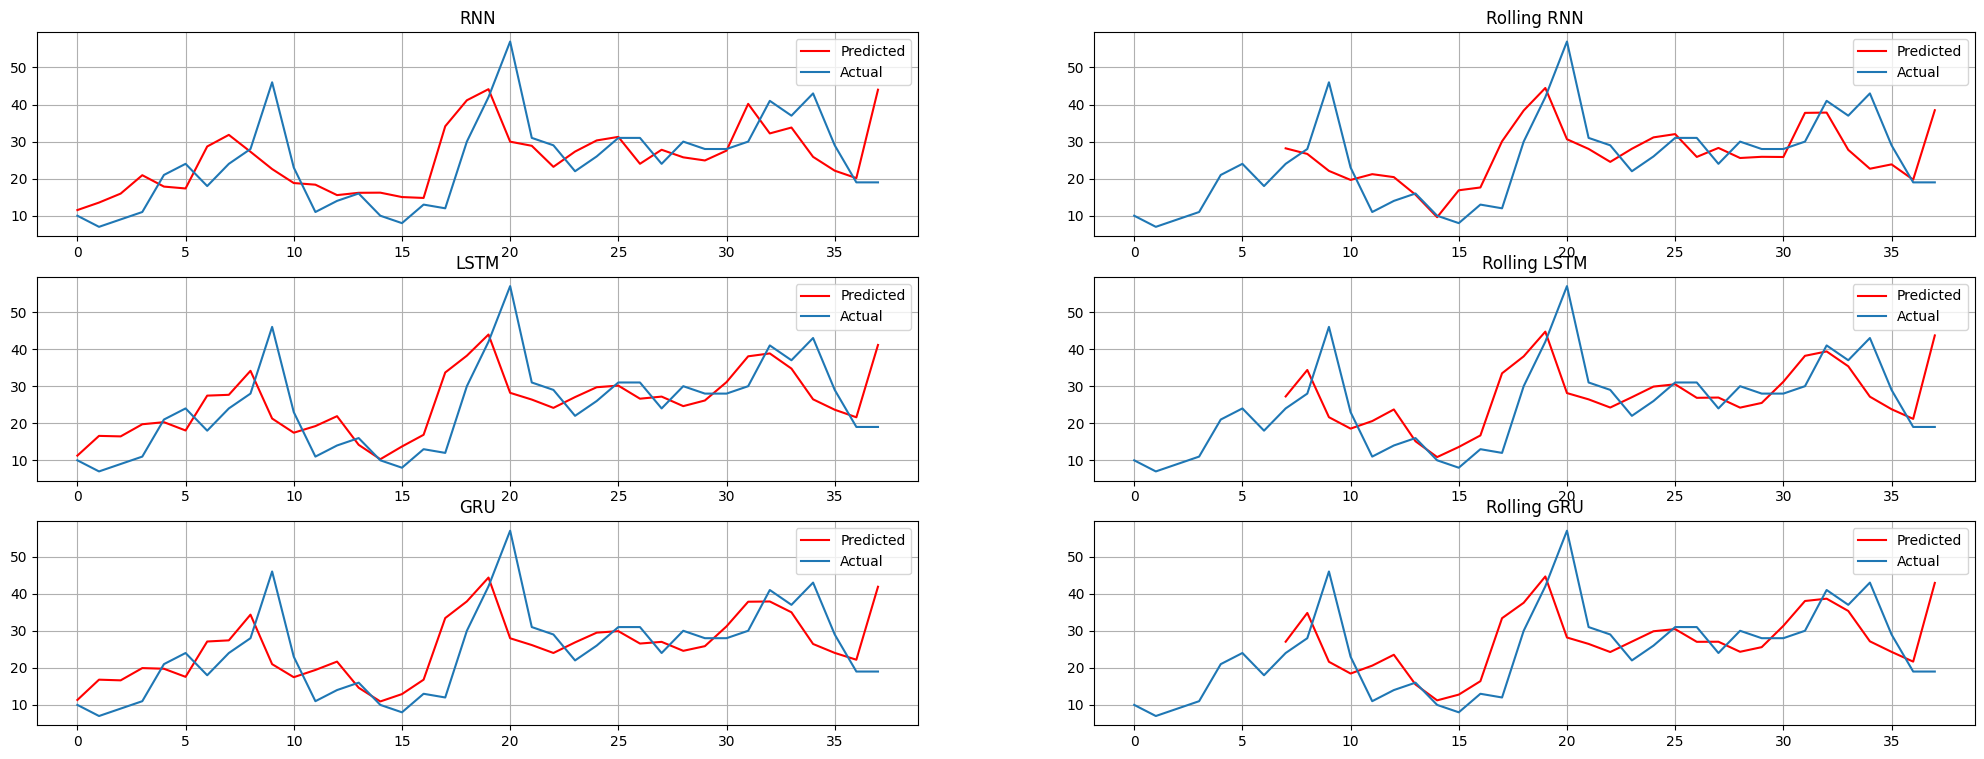

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

window_size = 7

rnn_padded = np.pad(rnn, (window_size, 0), 'constant', constant_values=np.nan)
lstm_padded = np.pad(lstm, (window_size, 0), 'constant', constant_values=np.nan)
gru_padded = np.pad(gru, (window_size, 0), 'constant', constant_values=np.nan)

# Now plot the predictions
fig, a = plt.subplots(3, 2, figsize=(25, 9))

# RNN (Non-Rolling)
a[0][0].plot(rnn_preds, "r-", label="Predicted")
a[0][0].plot(y_test_actual, label="Actual")
a[0][0].legend()
a[0][0].grid(True)
a[0][0].set_title('RNN')

# Rolling RNN
a[0][1].plot(rnn_padded, "r-", label="Predicted")
a[0][1].plot(y_test_actual, label="Actual") 
a[0][1].legend()
a[0][1].grid(True)
a[0][1].set_title('Rolling RNN')

# LSTM (Non-Rolling)
a[1][0].plot(lstm_preds, "r-", label="Predicted")
a[1][0].plot(y_test_actual, label="Actual")
a[1][0].legend()
a[1][0].grid(True)
a[1][0].set_title('LSTM')

# Rolling LSTM
a[1][1].plot(lstm_padded, "r-", label="Predicted")
a[1][1].plot(y_test_actual, label="Actual") 
a[1][1].legend()
a[1][1].grid(True)
a[1][1].set_title('Rolling LSTM')

# GRU (Non-Rolling)
a[2][0].plot(gru_preds, "r-", label="Predicted")
a[2][0].plot(y_test_actual, label="Actual")
a[2][0].legend()
a[2][0].grid(True)
a[2][0].set_title('GRU')

# Rolling GRU
a[2][1].plot(gru_padded, "r-", label="Predicted")
a[2][1].plot(y_test_actual, label="Actual") 
a[2][1].legend()
a[2][1].grid(True)
a[2][1].set_title('Rolling GRU')

# Save and show the figure
#plt.savefig('Summary.jpg', dpi=200)
plt.show()
